Stylization content

In [0]:
!wget -O /content/mona.jpg https://upload.wikimedia.org/wikipedia/commons/a/a9/Mona_Lisa_detail_face.jpg
!wget -O /content/marylin.jpg https://www.kazoart.com/blog/wp-content/uploads/2016/08/andy-warhol_marylin-monroe_thirddim-e1472130105363.jpg
!wget -O /content/starry.jpg https://upload.wikimedia.org/wikipedia/commons/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
!wget -O /content/thecafe.jpg https://upload.wikimedia.org/wikipedia/commons/0/09/Van_Gogh_-_Terrasse_des_Caf%C3%A9s_an_der_Place_du_Forum_in_Arles_am_Abend1.jpeg
!wget -O /content/son.jpg https://upload.wikimedia.org/wikipedia/ru/e/e5/Magritte_TheSonOfMan.jpg
!wget -O /content/castle.jpg http://static.coolconnections.ru/images/11860/standard/hd/329c4748c5bd3276c1712f2026b4000ca31b3b9d.jpg


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!unzip '/content/drive/My Drive/Colab Notebooks/style transfer/dataset' 'content/*' -d /content/

# Old method

Это старый дефолтный и очень медленный метод

In [0]:
_ = Transfer()
output = _.start_train("/content/mona.jpg", "/content/marylin.jpg")

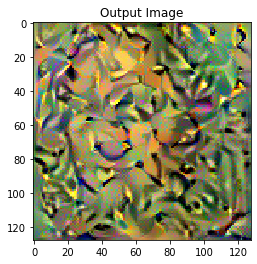

In [0]:
imshow(unloader(output), title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.show()
saveimg(unloader(output))

In [0]:
class Transfer(nn.Module):
  def __init__(self):
    super(Transfer, self).__init__()
    self.imsize = 128  

    self.loader = transforms.Compose([
        transforms.Resize(self.imsize),  # нормируем размер изображения
        transforms.CenterCrop(self.imsize),
        transforms.ToTensor()])  # превращаем в удобный формат

    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.cnn = models.vgg19(pretrained=True).features.to(self.device).eval()
    self.unloader = transforms.ToPILImage()

    # слои
    # контент лосс
    # стайл лосс
    self.content_layers = ['conv_4']
    self.style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    self.normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(self.device)
    self.normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(self.device)
    self.normalization = Normalization(self.normalization_mean, self.normalization_std).to(self.device)

  def start_train(self, content_img, style_img, num_steps=200,
            style_weight=20000, content_weight=1):
      """Run the style transfer."""
      print('Building the style transfer model..')
      style_img = self.image_loader(style_img)
      content_img = self.image_loader(content_img)
      input_img = content_img.clone()
      model, style_losses, content_losses = self.get_style_model_and_losses(self.cnn,
          self.normalization_mean, self.normalization_std, style_img, content_img, self.content_layers, self.style_layers)
      optimizer = self.get_input_optimizer(input_img)

      print('Optimizing..')
      run = [0]
      while run[0] <= num_steps:

          def closure():
              # correct the values 
              # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
              input_img.data.clamp_(0, 1)

              optimizer.zero_grad()

              model(input_img)

              style_score = 0
              content_score = 0

              for sl in style_losses:
                  style_score += sl.loss
              for cl in content_losses:
                  content_score += cl.loss
              
              #взвешивание ощибки
              style_score *= style_weight
              content_score *= content_weight

              loss = style_score + content_score
              loss.backward()

              run[0] += 1
              if run[0] % 50 == 0:
                  print("run {}:".format(run))
                  print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                      style_score.item(), content_score.item()))
                  print()

              return style_score + content_score

          optimizer.step(closure)

      # a last correction...
      input_img.data.clamp_(0, 1)

      return input_img

  def get_style_model_and_losses(self, cnn, normalization_mean, normalization_std,
                                  style_img, content_img,
                                  content_layers, style_layers):
      cnn = copy.deepcopy(cnn)

      # normalization module
      normalization = Normalization(normalization_mean, normalization_std).to(self.device)

      # just in order to have an iterable access to or list of content/syle
      # losses
      content_losses = []
      style_losses = []

      # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
      # to put in modules that are supposed to be activated sequentially
      model = nn.Sequential(normalization)

      i = 0  # increment every time we see a conv
      for layer in cnn.children():
          if isinstance(layer, nn.Conv2d):
              i += 1
              name = 'conv_{}'.format(i)
          elif isinstance(layer, nn.ReLU):
              name = 'relu_{}'.format(i)
              # The in-place version doesn't play very nicely with the ContentLoss
              # and StyleLoss we insert below. So we replace with out-of-place
              # ones here.
              #Переопределим relu уровень
              layer = nn.ReLU(inplace=False)
          elif isinstance(layer, nn.MaxPool2d):
              name = 'pool_{}'.format(i)
          elif isinstance(layer, nn.BatchNorm2d):
              name = 'bn_{}'.format(i)
          else:
              raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

          model.add_module(name, layer)

          if name in content_layers:
              # add content loss:
              target = model(content_img).detach()
              content_loss = ContentLoss(target)
              model.add_module("content_loss_{}".format(i), content_loss)
              content_losses.append(content_loss)

          if name in style_layers:
              # add style loss:
              target_feature = model(style_img).detach()
              style_loss = StyleLoss(target_feature)
              model.add_module("style_loss_{}".format(i), style_loss)
              style_losses.append(style_loss)

      # now we trim off the layers after the last content and style losses
      #выбрасываем все уровни после последенего styel loss или content loss
      for i in range(len(model) - 1, -1, -1):
          if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
              break

      model = model[:(i + 1)]

      return model, style_losses, content_losses

  def get_input_optimizer(self, input_img):
      # this line to show that input is a parameter that requires a gradient
      #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
      optimizer = optim.LBFGS([input_img.requires_grad_()]) 
      return optimizer


  def image_loader(self, image_name):
    image = Image.open(image_name)
    image = self.loader(image).unsqueeze(0)
    return image.to(self.device, torch.float)

In [0]:
class ContentLoss(nn.Module):
        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input


In [0]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = self.gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            G = self.gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

        def gram_matrix(self, input):
          batch_size , h, w, f_map_num = input.size()
          # b=number of feature maps
          # (h,w)=dimensions of a feature map (N=h*w)

          features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

          G = torch.mm(features, features.t())  # compute the gram product

          # we 'normalize' the values of the gram matrix
          # by dividing by the number of element in each feature maps.
          return G.div(batch_size * h * w * f_map_num)

In [0]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

# New real-time method

In [0]:
def gram_matrix(y):
  # Грам-матрица
  (b, ch, h, w) = y.size()
  features = y.view(b, ch, w * h)
  features_t = features.transpose(1, 2)
  gram = features.bmm(features_t) / (ch * h * w)
  return gram


def normalize_batch(batch):
  # Нормализация батча
  mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
  std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
  batch = batch.div_(255.0)
  return (batch - mean) / std

def load_image(filename, size=None, scale=None):
  # Грузит пикчи
  img = Image.open(filename)
  if size is not None:
      img = img.resize((size, size), Image.ANTIALIAS)
  elif scale is not None:
      img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
  return img

def imshow(image, title=None):
  # Показывает пикчи
  plt.imshow(image)
  if title is not None:
      plt.title(title)
  plt.pause(0.001) 

## Классы

In [0]:
class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

class TransformerNet(torch.nn.Module):
  '''
  Класс-трансформер
  https://arxiv.org/abs/1603.08155
  '''
  def __init__(self):
      super(TransformerNet, self).__init__()
      # Initial convolution layers
      self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
      self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
      self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
      self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
      self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
      self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
      # Residual layers
      self.res1 = ResidualBlock(128)
      self.res2 = ResidualBlock(128)
      self.res3 = ResidualBlock(128)
      self.res4 = ResidualBlock(128)
      self.res5 = ResidualBlock(128)
      # Upsampling Layers
      self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
      self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
      self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
      self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
      self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
      # Non-linearities
      self.relu = torch.nn.ReLU()

  def forward(self, X):
      y = self.relu(self.in1(self.conv1(X)))
      y = self.relu(self.in2(self.conv2(y)))
      y = self.relu(self.in3(self.conv3(y)))
      y = self.res1(y)
      y = self.res2(y)
      y = self.res3(y)
      y = self.res4(y)
      y = self.res5(y)
      y = self.relu(self.in4(self.deconv1(y)))
      y = self.relu(self.in5(self.deconv2(y)))
      y = self.deconv3(y)
      return y


class ConvLayer(torch.nn.Module):
  '''
  Конволюционный слой
  Количетсво входных слоев
  Количество выходных слоев
  kernel-size
  Stride shift size
  '''
  def __init__(self, in_size, out_size, kernel_size, stride):
      super(ConvLayer, self).__init__()
      reflection_padding = kernel_size // 2
      self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
      self.conv2d = torch.nn.Conv2d(in_size, out_size, kernel_size, stride)

  def forward(self, x):
      out = self.reflection_pad(x)
      out = self.conv2d(out)
      return out


class ResidualBlock(torch.nn.Module):
    """
    Остаточный слой
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    Количество каналов
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """
    Апсэмпл
    http://distill.pub/2016/deconv-checkerboard/
    Количетсво входных слоев
    Количество выходных слоев
    kernel-size
    Stride shift size
    Размер апсемпла
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [0]:
class StyleModel(nn.Module):
  def __init__(self, imsize=128):
    super(StyleModel, self).__init__()
    self.imsize = imsize 
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # я не очень понял как работает выдирание слоев
    # извините
    #self.content_layers = ['conv_4']
    #self.style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


  def stylize(self, model, content, content_scale):

    content = load_image(content, scale=content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content = content_transform(content)
    content = content.unsqueeze(0).to(self.device)

    with torch.no_grad():
        style_model = TransformerNet()
        state_dict = torch.load(model)

        for k in list(state_dict.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del state_dict[k]
        style_model.load_state_dict(state_dict)
        style_model.to(self.device)
        output = style_model(content).cpu()
    img = output[0].clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    return img

  def train(self, style_image, model_name, batch_size, epochs, content_weight=2000, style_weight=2000000, train_dataset = None):
    print(f'Now training {model_name}')
    # Переносимый стиль
    style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    style = load_image(style_image, size=self.imsize)
    style = style_transform(style)
    style = style.repeat(batch_size, 1, 1, 1).to(self.device)

    content_transform = transforms.Compose([
        transforms.Resize(self.imsize),
        transforms.CenterCrop(self.imsize),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])

    # Датасет для обучения
    if train_dataset == None:
      train_dataset = datasets.CIFAR10('/content/imgnet', transform=content_transform, download=True)
    else:
      train_dataset = datasets.ImageFolder(train_dataset, content_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    transformer = TransformerNet().to(self.device)
    optimizer = optim.Adam(transformer.parameters(), lr=1e-3)
    loss = nn.MSELoss()
    #self.cnn = models.vgg19(pretrained=True).features.to(self.device).eval()
    vgg = Vgg16(requires_grad=False).to(self.device)

    features_style = vgg(normalize_batch(style))
    gram_style = [gram_matrix(label) for label in features_style]

    for epoch in range(epochs):
      # говорим модели что трейним ее
      transformer.train()
      epoch_content_loss = 0.
      epoch_style_loss = 0.
      count = 0
      for batch_id, (x, _) in enumerate(train_loader):
          size_of_batch = len(x) #n_batch
          count += size_of_batch 
          optimizer.zero_grad()

          x = x.to(self.device)
          y = transformer(x)

          y = normalize_batch(y)
          x = normalize_batch(x)

          hypo = vgg(y)
          x = vgg(x)
          #print(hypo)

          content_loss = content_weight * loss(hypo.relu2_2, x.relu2_2)

          style_loss = 0.
          for y_feature, gram_stl in zip(hypo, gram_style):
              gram_hypo = gram_matrix(y_feature)
              style_loss += loss(gram_hypo, gram_stl[:size_of_batch, :, :])
          style_loss *= style_weight

          total_loss = content_loss + style_loss
          total_loss.backward()
          optimizer.step()

          epoch_content_loss += content_loss.item()
          epoch_style_loss += style_loss.item()

      msg = "Epoch {}: content: {}\tstyle: {}\ttotal: {}".format(
          epoch,
          epoch_content_loss / (batch_id + 1),
          epoch_style_loss / (batch_id + 1),
          (epoch_content_loss + epoch_style_loss) / (batch_id + 1)
      )
      print(msg)
      with torch.no_grad():
        for _, (x, _) in enumerate(train_loader):
          x = x.to(self.device)
          y = transformer(x).cpu()
          #print(x)
          #print(x.size())
          img = y[0].cpu().clone().clamp(0, 255).numpy()
          img = img.transpose(1, 2, 0).astype("uint8")
          img = Image.fromarray(img)
          imshow(img)
          break

    # save model
    transformer.eval().cpu()
    torch.save(transformer.state_dict(), f'/content/drive/My Drive/Colab Notebooks/style transfer/{model_name}.model')

    print(f"\nDone, trained model {model_name}.model saved at google drive")


## Получение даты

In [0]:
!mkdir /content/dataset

In [0]:
data = []
path = "/content/drive/My Drive/Image raw data for 100 categories/"
for i in range(5):
  data.append(random.choice(os.listdir(path)))

print(data)
for label in data:
  print(f'Extracting {label[:-4]}')
  if not os.path.isdir(f'/content/dataset/{label[:-4]}'):
    os.mkdir(f'/content/dataset/{label[:-4]}')
  print(f"unrar e '{path}{label}' /content/dataset/{label[:-4]}")
  result = subprocess.call(['unrar', f"e '{path}{label}' '/content/dataset/{label[:-4]}''"])
  if result != 0:
      print(f'Got {result} in {i}')


['bottle.rar', 'dragonfly.rar', 'ant.rar', 'eraser.rar', 'mug.rar']
Extracting bottle
unrar e '/content/drive/My Drive/Image raw data for 100 categories/bottle.rar' /content/dataset/bottle
Got 7 in 4
Extracting dragonfly
unrar e '/content/drive/My Drive/Image raw data for 100 categories/dragonfly.rar' /content/dataset/dragonfly
Got 7 in 4
Extracting ant
unrar e '/content/drive/My Drive/Image raw data for 100 categories/ant.rar' /content/dataset/ant
Got 7 in 4
Extracting eraser
unrar e '/content/drive/My Drive/Image raw data for 100 categories/eraser.rar' /content/dataset/eraser
Got 7 in 4
Extracting mug
unrar e '/content/drive/My Drive/Image raw data for 100 categories/mug.rar' /content/dataset/mug
Got 7 in 4


In [0]:
!unrar e '/content/drive/My Drive/Image raw data for 100 categories/bottle.rar' /content/dataset/bottle

In [0]:
!unrar e '/content/drive/My Drive/Image raw data for 100 categories/dragonfly.rar' /content/dataset/dragonfly
!unrar e '/content/drive/My Drive/Image raw data for 100 categories/ant.rar' /content/dataset/ant
!unrar e '/content/drive/My Drive/Image raw data for 100 categories/eraser.rar' /content/dataset/eraser
!unrar e '/content/drive/My Drive/Image raw data for 100 categories/mug.rar' /content/dataset/mug

In [0]:
txt_data = []
for label in data:
  for i in range(5):
    got = random.choice(os.listdir(f'/content/dataset/{label[:-4]}'))
    txt_data.append(f'/content/dataset/{label[:-4]}/'+got)

print(txt_data)

['/content/dataset/bottle/liquor bottle.txt', '/content/dataset/bottle/wine bottle.txt', '/content/dataset/bottle/glasses bottle.txt', '/content/dataset/bottle/pen bottle.txt', '/content/dataset/bottle/turkey bottle.txt', '/content/dataset/dragonfly/dragonfly flew.txt', '/content/dataset/dragonfly/blue dragonfly.txt', '/content/dataset/dragonfly/beautiful dragonfly.txt', '/content/dataset/dragonfly/dragonfly wing.txt', '/content/dataset/dragonfly/blue dragonfly.txt', '/content/dataset/ant/other ant.txt', '/content/dataset/ant/flying ant.txt', '/content/dataset/ant/ant fly.txt', '/content/dataset/ant/ant gave.txt', '/content/dataset/ant/ant legs.txt', '/content/dataset/eraser/pink eraser.txt', '/content/dataset/eraser/electric eraser.txt', '/content/dataset/eraser/eraser have.txt', '/content/dataset/eraser/eraser knife.txt', '/content/dataset/eraser/eraser find.txt', '/content/dataset/mug/handsome mug.txt', '/content/dataset/mug/mug coffee.txt', '/content/dataset/mug/left mug.txt', '/co

In [0]:
print(len(os.listdir('/content/cleaned_dataset/')))
for path in txt_data:
  name = os.path.basename(path)[:-4]
  dataset_path = '/content/cleaned_dataset/'
  if not os.path.isdir(dataset_path):
    os.mkdir(dataset_path)
  with open(path, 'r') as file:  
    data = file.readlines() 
    for i in range(len(data)):
      formats = ['jpg', 'png', 'PNG', 'JPG',
                 'gif', 'GIF', 'bmp', 'BMP']
      if data[i][-4:-1] in formats:
        #print(f'{i} good')
        if os.path.isfile(f'{dataset_path}/{name.split(" ")[0]}_{i}.jpg'):
          continue
        else:
          print(f'Downloading {data[i][:-1]}')
          result = subprocess.call(['wget', f'--output-document={dataset_path}/{name.split(" ")[0]}_{i}.jpg', data[i][:-1]])
          if result != 0:
            print(f'Got {result} in {i}')
      if i % 200 == 0:
        print(f'downloaded {i}')

1914
downloaded 0


In [0]:
# cleanup
dirpath = '/content/cleaned_dataset/'
for item in os.listdir(dirpath):
  try:
    img = Image.open(f'{dirpath}/{item}') # open the image file
    img.verify() # verify that it is, in fact an image
    #os.rename(f'{dirpath}/{item}', f'{self.root_dir}/{item}')
  except (IOError, SyntaxError) as e:
    print('Corrupted file:', item) # print out the names of corrupt files
    os.remove(f'{dirpath}/{item}')

print('cleaned len', len(os.listdir(dirpath)))

Corrupted file: flying_59.jpg
Corrupted file: blue_2.jpg
Corrupted file: other_48.jpg
Corrupted file: mug_79.jpg
Corrupted file: other_4.jpg
Corrupted file: glasses_143.jpg
Corrupted file: glasses_22.jpg
Corrupted file: handsome_90.jpg
Corrupted file: beautiful_3.jpg
Corrupted file: pen_50.jpg
Corrupted file: liquor_115.jpg
Corrupted file: liquor_87.jpg
Corrupted file: glasses_12.jpg
Corrupted file: left_52.jpg
Corrupted file: turkey_189.jpg
Corrupted file: turkey_134.jpg
Corrupted file: flying_9.jpg
Corrupted file: glasses_123.jpg
Corrupted file: liquor_137.jpg
Corrupted file: turkey_58.jpg
Corrupted file: liquor_117.jpg
Corrupted file: ant_62.jpg
Corrupted file: wine_76.jpg
Corrupted file: mug_89.jpg
Corrupted file: beautiful_20.jpg
Corrupted file: wine_3.jpg
Corrupted file: liquor_49.jpg
Corrupted file: mug_45.jpg
Corrupted file: ant_66.jpg
Corrupted file: eraser_57.jpg
Corrupted file: electric_7.jpg
Corrupted file: ant_80.jpg
Corrupted file: glasses_38.jpg
Corrupted file: eraser_94

In [0]:
!zip -r '/content/drive/My Drive/Colab Notebooks/style transfer/' '/content/cleaned_dataset/'

  adding: content/cleaned_dataset/ (stored 0%)
  adding: content/cleaned_dataset/liquor_150.jpg (deflated 2%)
  adding: content/cleaned_dataset/turkey_182.jpg (deflated 1%)
  adding: content/cleaned_dataset/other_51.jpg (deflated 5%)
  adding: content/cleaned_dataset/pink_50.jpg (deflated 0%)
  adding: content/cleaned_dataset/flying_87.jpg (deflated 1%)
  adding: content/cleaned_dataset/glasses_43.jpg (deflated 0%)
  adding: content/cleaned_dataset/liquor_189.jpg (deflated 2%)
  adding: content/cleaned_dataset/flying_31.jpg (deflated 4%)
  adding: content/cleaned_dataset/turkey_24.jpg (deflated 0%)
  adding: content/cleaned_dataset/pink_60.jpg (deflated 0%)
  adding: content/cleaned_dataset/liquor_3.jpg (deflated 14%)
  adding: content/cleaned_dataset/mug_18.jpg (deflated 0%)
  adding: content/cleaned_dataset/glasses_165.jpg (deflated 2%)
  adding: content/cleaned_dataset/flying_92.jpg (deflated 1%)
  adding: content/cleaned_dataset/pink_57.jpg (deflated 25%)
  adding: content/cleaned_

## Обучение

In [3]:
!nvidia-smi 

Wed Feb 12 12:41:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Обучение Мэрлин Монро
torch.cuda.empty_cache()
_ = StyleModel()
_.train('/content/marylin.jpg', 'marylin_2000_200', 5, 3, 2000, 200) # никак
_.train('/content/marylin.jpg', 'marylin_2000_2', 5, 3, 2000, 2)  # никак
_.train('/content/marylin.jpg', 'marylin_1e5_1e8', 5, 3, 1e5, 1e8) # никак
_.train('/content/marylin.jpg', 'marylin_1e5_1e9', 5, 3, 1e5, 1e9) # похоже
_.train('/content/marylin.jpg', 'marylin_1e6_1e10', 5, 3, 1e6, 1e10) # также
_.train('/content/marylin.jpg', 'marylin_1e10_1e6', 5, 3, 1e10, 1e6) # никак

marylin_1e6_1e10.model is best

In [0]:
_ = StyleModel()
outs = []
for model in ['marylin_2000_200', 'marylin_2000_2', 'marylin_1e5_1e8', 'marylin_1e5_1e9', 'marylin_1e6_1e10']:
  outs.append(_.stylize(f'/content/drive/My Drive/Colab Notebooks/style transfer/{model}.model', '/content/mona.jpg', 10))

Now training mona_1e6_1e10
Files already downloaded and verified
Epoch 0: content: 565519.01453125	style: 913704.74765625	total: 1479223.7621875


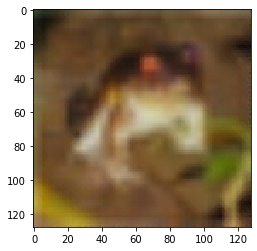

Epoch 1: content: 498284.88016875	style: 859557.99783125	total: 1357842.878


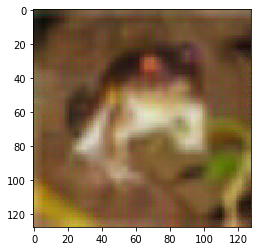

Epoch 2: content: 484842.73133125	style: 840636.389025	total: 1325479.12035625


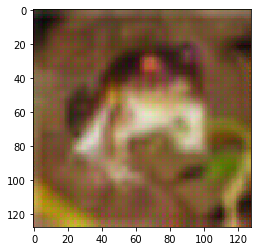


Done, trained model mona_1e6_1e10.model saved at google drive
Now training son_1e6_1e10
Files already downloaded and verified
Epoch 0: content: 758222.74816875	style: 1797834.437075	total: 2556057.18524375


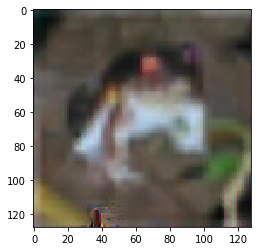

Epoch 1: content: 701915.958925	style: 1691568.3107125	total: 2393484.2696375


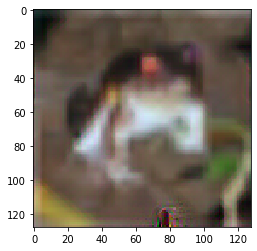

Epoch 2: content: 686598.35565625	style: 1664092.6968625	total: 2350691.05251875


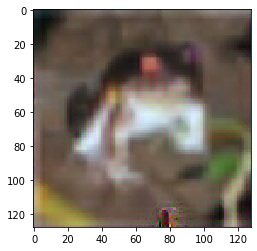


Done, trained model son_1e6_1e10.model saved at google drive
Now training starry_1e6_1e10


DecompressionBombError: ignored

In [0]:
torch.cuda.empty_cache()
_ = StyleModel()
_.train('/content/mona.jpg', 'mona_1e6_1e10', 5, 3, 1e6, 1e10)
_.train('/content/son.jpg', 'son_1e6_1e10', 5, 3, 1e6, 1e10)

Now training starry_1e6_1e10
Files already downloaded and verified
Epoch 0: content: 2238358.8253625	style: 1817909.6113625	total: 4056268.436725


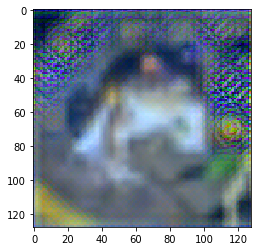

Epoch 1: content: 2113506.0599	style: 1700025.79955	total: 3813531.85945


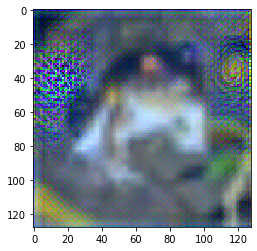

Epoch 2: content: 2071217.9282875	style: 1689152.6906375	total: 3760370.618925


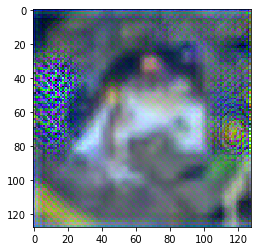


Done, trained model starry_1e6_1e10.model saved at google drive
Now training thecafe_1e6_1e10
Files already downloaded and verified


In [0]:
Image.MAX_IMAGE_PIXELS = None
del _
torch.cuda.empty_cache()
_ = StyleModel()
_.train('/content/starry.jpg', 'starry_1e6_1e10', 5, 3, 1e6, 1e10)
_.train('/content/thecafe.jpg', 'thecafe_1e6_1e10', 5, 3, 1e6, 1e10)
_.train('/content/castle.jpg', 'castle_1e6_1e10', 5, 3, 1e6, 1e10)

#Сервер

In [0]:
!pip3 install telepot

In [0]:
!pip install flask-ngrok

In [0]:
!sudo apt-get install unrar

In [0]:
import torch
import numpy as np
import requests
import json
import copy
import os
import random
import re
import subprocess

from collections import namedtuple

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision.models as models

import matplotlib.pyplot as plt

from PIL import Image

from flask_ngrok import run_with_ngrok
from flask import Flask, request

import telepot
from telepot.namedtuple import ReplyKeyboardMarkup

In [0]:
def get_ngrok_url():
    url = "http://localhost:4040/api/tunnels"
    res = requests.get(url)
    res_unicode = res.content.decode("utf-8")
    res_json = json.loads(res_unicode)
    return res_json["tunnels"][0]["public_url"]

In [0]:
 def unloader(image):
   # функция для отрисовки изображения
   # больше не юзается
    unl = transforms.ToPILImage()
    image = image.cpu().clone()   
    image = image.squeeze(0)      
    image = unl(image)
    return image

def saveimg(image, name):
  # Сохранить пикчу
  image.save(name, 'JPEG')

In [29]:
app = Flask(__name__)
run_with_ngrok(app)

secret_key = 'YOURSECRETTHERE'
bot_key = 'YOURKEYTHERE'

secret = secret_key
bot = telepot.Bot(bot_key)

bot_keyboard = ReplyKeyboardMarkup(keyboard=[['Select style', 'How to use', 'About']])
style_keyboard = ReplyKeyboardMarkup(keyboard=[['Marylin Monro', 'Mona Lisa α', 'The cafe Terrace α']]) #'Starry Night α',

howto = '''1. Send source photo.
3. Wait for stylized photo.
4. ???
5. PROFIT!
'''

about = '''🐱‍👓 By @Shashkovich
❤ For MIPT Deep Learning School, fall 2019 - winter 2020. 
⚙ Source code - https://github.com/AlexShashkov/mipt_style_transfer_bot
'''

#transfer = Transfer()
model = StyleModel()
user_used_styles = {}

def start_hello(bot, chat_id):
  bot.sendSticker(chat_id, 'CAACAgIAAxkBAAIb_l4t0Rb2dnI87j1qb-MQRQn6O6bOAAK5AAPA-wgAAZyx9AZ6cc9LGAQ')
  bot.sendMessage(chat_id, 'Oh, hoi!',
              reply_markup=bot_keyboard)
  
def set_style(chat_id, style):
  user_used_styles[chat_id] = style
  bot.sendMessage(chat_id, f'Model changed to {style}',
            reply_markup=bot_keyboard)

answers = {
    '/start':start_hello, 
    'Select style':(lambda bot, chat_id: bot.sendMessage(chat_id, 'Pick your style, please',
                            reply_markup=style_keyboard)),
    'How to use':(lambda bot, chat_id: bot.sendMessage(chat_id, howto)),
    'About':(lambda bot, chat_id: bot.sendMessage(chat_id, about)),
    'Marylin Monro':(lambda _, chat_id: set_style(chat_id, 'marylin_1e6_1e10.model')),
    'Mona Lisa α':(lambda _, chat_id: set_style(chat_id, 'mona_1e6_1e10.model')),
    #'Starry Night α':(lambda _, chat_id: set_style(chat_id, 'starry_1e6_1e10.model')),
    'The cafe Terrace α':(lambda _, chat_id: set_style(chat_id, 'thecafe_1e6_1e10.model')),
}
def message_handler(bot, chat_id, message):
  try:
    answers[message](bot, chat_id)
  except KeyError as er:
    bot.sendSticker(chat_id, 'CAACAgIAAxkBAAImUV5D_OqlGuHUwf93XnXv1_fTjHr8AAK6AAPA-wgAAZJvD72Lo0lLGAQ')
    bot.sendMessage(chat_id, 'Bro Im literally a parrot, I cant talk.')
  

@app.before_first_request
def get_webhook():
    addr = get_ngrok_url()
    addr = addr.replace('http:', 'https:')
    bot.setWebhook("{}/{}".format(addr, secret), max_connections=20)
    print('Webhook set succesfully')

@app.route('/')
def home():
  return '''
  <img src="https://media.giphy.com/media/xjTIBA4gjvXIQ/giphy.gif" width="450" height="450" alt="Server is up">
  <h1> Server is up </h1>
  '''

@app.route('/{}'.format(secret), methods=["POST"])
def telegram_webhook():
    update = request.get_json()
    if "message" in update:
        message = update["message"]
        chat_id = message["chat"]["id"]
        if not os.path.isdir(f'/content/{chat_id}'):
          os.mkdir(f'/content/{chat_id}')
          user_used_styles[chat_id] = 'marylin_1e6_1e10.model'
        if "text" in message:
            text = message["text"]
            message_handler(bot, chat_id, text)
        elif "photo" in message:
            used_model = user_used_styles[chat_id]
            file_id = message["photo"][0]["file_id"]
            if not os.path.isfile(f'/content/{chat_id}/content.jpg'):
              bot.download_file(file_id, f'/content/{chat_id}/content.jpg')
              bot.sendMessage(chat_id, 'Please wait, your image is being created')
              #img = transfer.start_train(f'/content/{chat_id}/target.jpg', f'/content/{chat_id}/style.jpg')
              #img = unloader(img)
              img = model.stylize(f'/content/drive/My Drive/Colab Notebooks/style transfer/{used_model}', f'/content/{chat_id}/content.jpg', None)
              os.remove(f'/content/{chat_id}/content.jpg')
              bot.sendMessage(chat_id, 'There you go!')
              saveimg(img, f'/content/{chat_id}/output.jpg')
              bot.sendPhoto(chat_id, open(f'/content/{chat_id}/output.jpg', 'rb'))
    return "OK"

# As of Flask 1.0, the WSGI server included with Flask is run in threaded mode by default.
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://587e244c.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [12/Feb/2020 13:41:57] "GET / HTTP/1.1" 200 -


Webhook set succesfully


127.0.0.1 - - [12/Feb/2020 13:41:58] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [12/Feb/2020 13:42:07] "POST /keksossecret HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2020 13:42:11] "POST /keksossecret HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2020 13:42:26] "POST /keksossecret HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2020 13:42:31] "POST /keksossecret HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2020 13:42:41] "POST /keksossecret HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2020 13:42:49] "POST /keksossecret HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2020 13:43:03] "POST /keksossecret HTTP/1.1" 200 -
